nu 1
n_test 0


WARNING    Removing unsupported flag '-w' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-O3' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-ffast-math' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-fno-finite-math-only' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Removing unsupported flag '-std=c++11' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Cannot use Cython, a test compilation failed: command 'g++' failed: No such file or directory (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cytho

n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
nu 2
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
nu 3
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
nu 4
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
nu 5
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
nu 6
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
nu 7
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
nu 8
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
nu 9
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9
nu 10
n_test 0
n_test 1
n_test 2
n_test 3
n_test 4
n_test 5
n_test 6
n_test 7
n_test 8
n_test 9


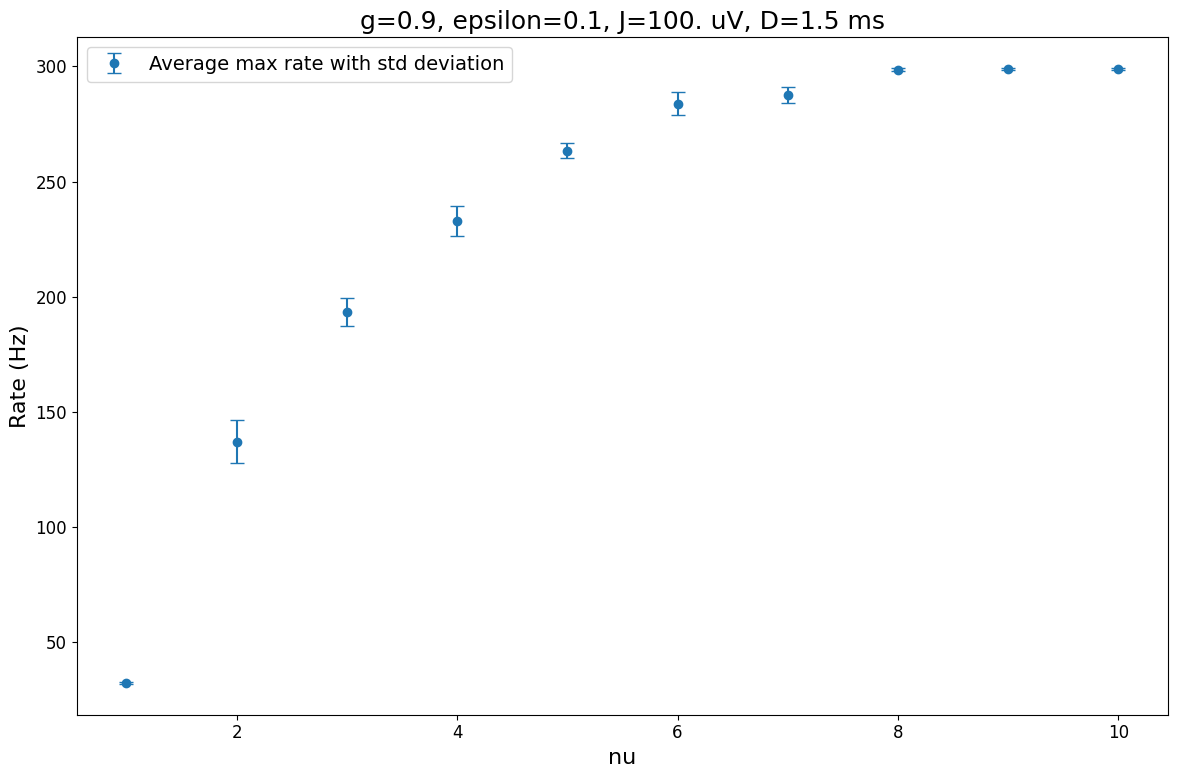

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from scipy.optimize import curve_fit


plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'legend.fontsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

def sim(g, nu_ext_over_nu_thr, sim_time, epsilon, J, D, plot=False):
    start_scope()
    # network parameters
    N_E = 800
    gamma = 0.25
    N_I = round(gamma * N_E)
    N = N_E + N_I
    C_E = epsilon * N_E
    C_ext = C_E

    # neuron parameters
    tau = 20 * ms
    theta = 20 * mV
    V_r = 10 * mV
    tau_rp = 2 * ms

    # synapse parameters
    D = 1.5 * ms

    # external stimulus
    nu_thr = theta / (J * C_E * tau)
    nu_ext = nu_ext_over_nu_thr * nu_thr

    defaultclock.dt = 0.1 * ms

    neurons = NeuronGroup(N,
                          "dv/dt = -v/tau : volt (unless refractory)",
                          threshold="v > theta",
                          reset="v = V_r",
                          refractory=tau_rp,
                          method="exact")
    excitatory_neurons = neurons[:N_E]
    inhibitory_neurons = neurons[N_E:]

    exc_synapses = Synapses(excitatory_neurons, target=neurons, on_pre="v += J", delay=D)
    exc_synapses.connect(p=epsilon)

    inhib_synapses = Synapses(inhibitory_neurons, target=neurons, on_pre="v += -g*J", delay=D)
    inhib_synapses.connect(p=epsilon)

    external_poisson_input = PoissonInput(
        target=neurons, target_var="v", N=C_ext, rate=nu_ext, weight=J
    )

    rate_monitor = PopulationRateMonitor(neurons)
    spike_monitor = SpikeMonitor(neurons[:50])

    # Запуск симуляции
    run(sim_time)

    rate = rate_monitor.rate/Hz - np.mean(rate_monitor.rate/Hz)

    # Gaussian for the fit
    def func(x, a, x0, sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))

    N = len(rate_monitor.t) # number of samples
    sampling_rate = 10000 # 1/defaultclock.dt   
    max_point = int(N*300/sampling_rate)
    x = rfftfreq(N, d=1/sampling_rate)
    x = x[:max_point]
    yn = 2*np.abs(rfft(rate))/N
    yn = yn[:max_point]

    max_rate = np.argmax(yn)

    if plot:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'D = {g}')

        # Первый график (спайки)
        plt.subplot(311)
        plt.plot(spike_monitor.t / ms, spike_monitor.i, '|')
        plt.xlabel('Time (ms)')
        plt.ylabel('Neuron index')
        plt.xlim([0, 250])

        # Второй график (частота)
        plt.subplot(312)
        plt.plot(rate_monitor.t / ms, rate_monitor.rate / Hz)
        plt.xlabel('Time (ms)')
        plt.ylabel('Rate (Hz)')
        plt.xlim([0, 250])

        # Третий график (функция)
        plt.subplot(313)
        plt.plot(x, yn, c='k', label='Function')
        plt.xlabel('Rate (Hz)')
        plt.xlim([0, 250])
        plt.show()


    return rate_monitor, spike_monitor, max_rate

tests = np.arange(0, 10, 1)
nu_values = np.arange(1, 11, 1)

g = 0.9
sim_time = 1000 * ms
epsilon = 0.1
J = 0.1 * mV
D = 1.5 * ms

mean_rates = []
std_rates = []

for nu in nu_values:
    print('nu', round(nu, 1))
    max_rates_for_g = []
    for n_test in tests:
        print('n_test', n_test)
        rate_monitor, spike_monitor, max_rate = sim(g, round(nu, 1), sim_time, epsilon, J, D)
        max_rates_for_g.append(max_rate)
    
    mean_rates.append(np.mean(max_rates_for_g))
    std_rates.append(np.std(max_rates_for_g))

# Построение графика
plt.figure(figsize=(12, 8))
plt.errorbar(nu_values, mean_rates, yerr=std_rates, fmt='o', capsize=5, label='Average max rate with std deviation')
plt.ylabel('Rate (Hz)')
plt.xlabel('nu')
plt.title(f'g={g}, epsilon={epsilon}, J={J}, D={D}')
plt.tight_layout()
plt.legend()
plt.show()